<a href="https://colab.research.google.com/github/robgon-art/MachineRay2/blob/main/MachineRay2_Image_Generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **MachineRay2** - Image Generation
By Robert. A Gonsalves
![MachineRay Output](https://raw.githubusercontent.com/robgon-art/MachineRay2/main/sample%202%20wide.jpg)

This is a project that uses AI to create abstract art.

I gathered images of abstract paintings from WikiArt.org, processed them, and fed them into StyleGAN2 ADA at the size of 1024x1024.
I trained the GAN for four days on a GPU using Google Colab.
I then processed the output images by adjusting the aspect ratio and running them through another ANN for a super-resolution resize.
The resultant images are 4096 pixels wide or tall, depending on the aspect ratio.

This Google Colaboratory allows you to generate unique abstract art automatically.

The source code and generated images are released under the [CC BY-NC-SA license](https://creativecommons.org/licenses/by-nc-sa/4.0/).</br>
![CC BY-NC-SA](https://licensebuttons.net/l/by-nc-sa/3.0/88x31.png)

# **Initalize the System**
Hit the Run Cell (play) button to intialize the system.

In [1]:
# %tensorflow_version 2.x
!git clone https://github.com/NVlabs/stylegan2-ada-pytorch
!wget -O "network-snapshot-000188.pkl" "https://www.dropbox.com/s/ya3swqh2t165nkn/network-snapshot-000188.pkl?dl=0"
!wget -O painting_info.txt "https://www.dropbox.com/s/h2bktown2oq2avq/painting_info.txt?dl=0"
inited_ISR = False

Cloning into 'stylegan2-ada-pytorch'...
remote: Enumerating objects: 131, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 131 (delta 0), reused 1 (delta 0), pack-reused 128
Receiving objects: 100% (131/131), 1.13 MiB | 2.40 MiB/s, done.
Resolving deltas: 100% (57/57), done.
--2024-06-10 03:01:47--  https://www.dropbox.com/s/ya3swqh2t165nkn/network-snapshot-000188.pkl?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.2.18, 2620:100:6035:18::a27d:5512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.2.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /scl/fi/jobri7f4n26rg4j2a1jvw/network-snapshot-000188.pkl?rlkey=zm1mx4iaa808uzoxn0n3g46pu&dl=0 [following]
--2024-06-10 03:01:48--  https://www.dropbox.com/scl/fi/jobri7f4n26rg4j2a1jvw/network-snapshot-000188.pkl?rlkey=zm1mx4iaa808uzoxn0n3g46pu&dl=0
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting res

# **Generate a Sample of Paintings and Show Thumbnails**
Hit the Run Cell button to generate 21 thumbnail images using MachineRay.

Streaming output truncated to the last 5000 lines.
  File "<frozen importlib._bootstrap_external>", line 1176, in create_module
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
ImportError: /root/.cache/torch_extensions/py310_cu121/upfirdn2d_plugin/upfirdn2d_plugin.so: cannot open shared object file: No such file or directory

  warnings.warn('Failed to build CUDA kernels for upfirdn2d. Falling back to slow reference implementation. Details:\n\n' + traceback.format_exc())
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
/content/stylegan2-ada-pytorch/torch_utils/ops/upfirdn2d.py:34: UserWarning: Failed to build CUDA kernels for upfirdn2d. Falling back to slow reference implementation. Details:

Traceback (most recent call last):
  File "/content/stylegan2-ada-pytorch/torch_utils/ops/upfirdn2d.py", line 32, in _init
    _plugin = custom_ops.get_plugin('upfirdn2d_plugin', sources=sources, extra_cuda_cflags=['--use_fast_math'])
  File "/content/stylega

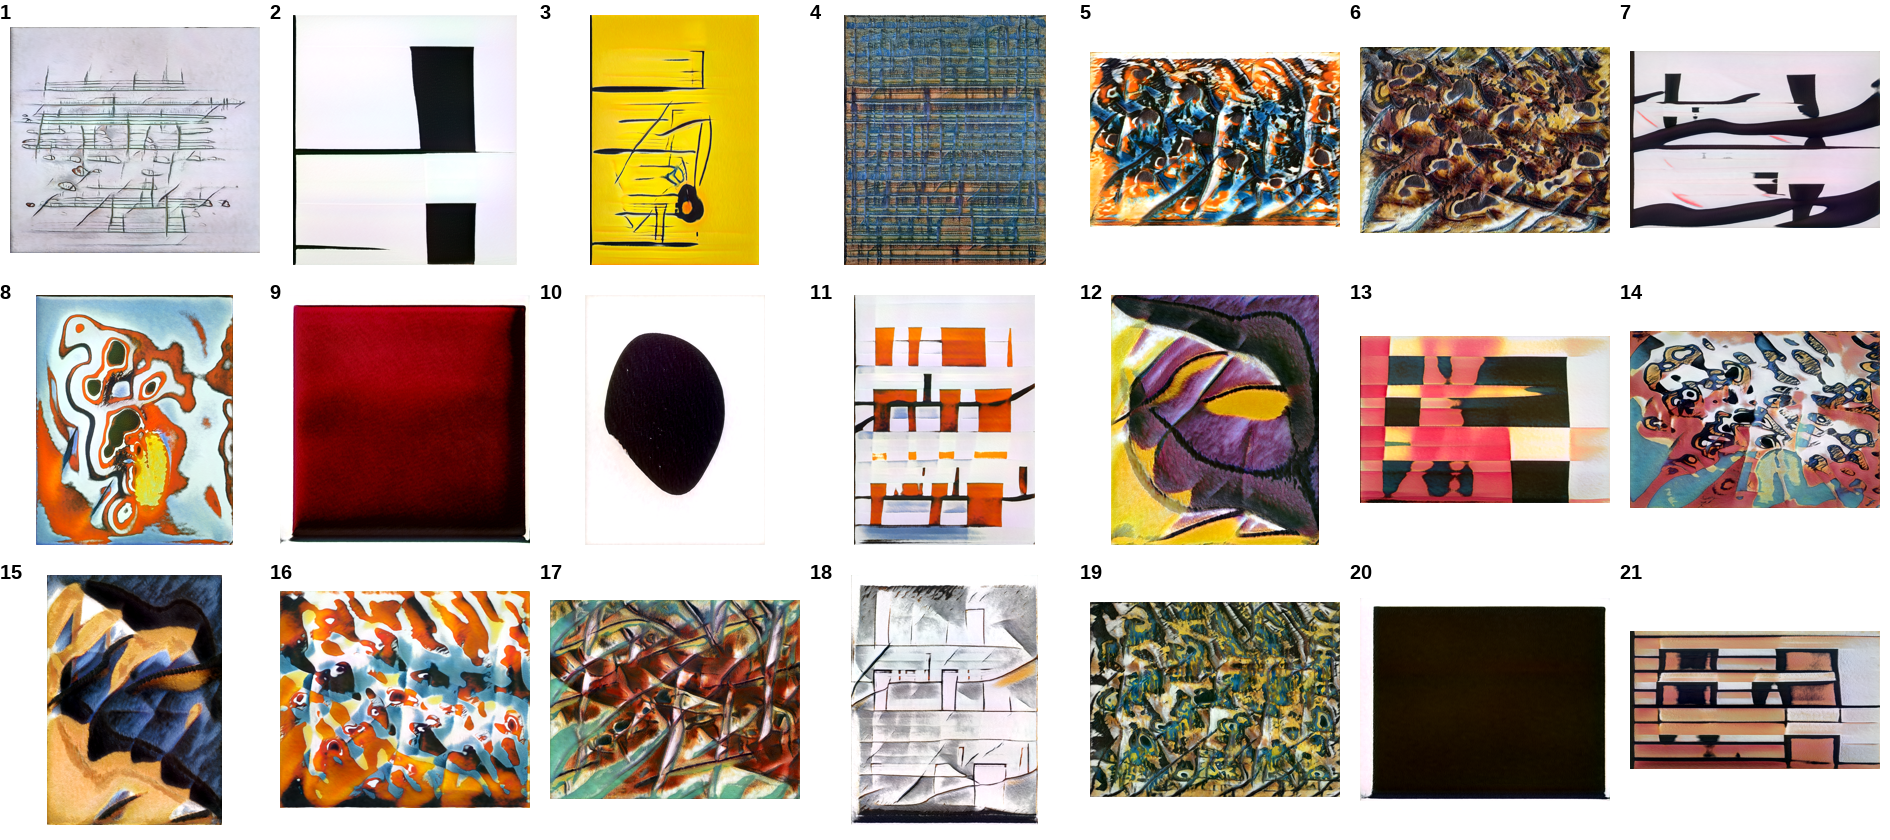

In [2]:
%tensorflow_version 2.x
import os
from PIL import Image, ImageOps, ImageFont, ImageDraw
import numpy as np
import random
import warnings

# Disable all warningd - NOTE: comment out the next line for debugging
warnings.filterwarnings("ignore")

# Clear out the results folder if it exists
if os.path.exists("results"):
  !rm -r results

# Pick a number, any number
seed = random.randint(0,100000)
seed_arg = "--seeds="

for i in range(20):
  seed_arg += str(seed+i) + ","
seed_arg += str(seed+20)

# Generate the images
!python /content/stylegan2-ada-pytorch/generate.py $seed_arg --trunc=1.25  \
  --outdir results --network=network-snapshot-000188.pkl

# Initialize the x and y arrays
x = np.linspace(0, 849, 850)
y = np.empty(shape=(850))

# Read the file containing the paintings and aspect ratios
info_file = open('painting_info.txt', 'r')
lines = info_file.readlines()

# Use this font
fnt = ImageFont.truetype('/usr/share/fonts/truetype/liberation/LiberationSans-Bold.ttf', 20)

# Loop through the lines, capturing the aspect ratio in the y array
count = 0
for line in lines:
  parts = line.split(' ')
  if len(parts) == 2 and len(parts[1]) > 0:
    y[count] = parts[1]
  count += 1

# Sort the values
y = np.sort(y)

# Use piecewise linear interpolation
def get_aspect_ratio():
  input_x = np.random.rand(1)*850
  y_interp = np.interp(input_x, x, y)
  return y_interp[0]

def get_concat_h(im1, im2):
    dst = Image.new('RGB', (im1.width + im2.width, im1.height))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (im1.width, 0))
    return dst

def get_concat_v(im1, im2):
    dst = Image.new('RGB', (im1.width, im1.height + im2.height))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (0, im1.height))
    return dst

# Get all the image file names
image_files = []
for root, dirs, files in os.walk("results"):
    files.sort()
    for file in files:
        if file.endswith(".png"):
             image_files.append(os.path.join(root, file))

# Generate a grid of thumbnails
aspect_ratios = []
size = 250
count = 0
for j in range(0, 3):
  for i in range(0, 7):
    tile = Image.open(image_files[count])
    aspect = get_aspect_ratio()
    aspect_ratios.append(aspect)

    if aspect<1:
      newsize = (int(size * aspect), size)
    else:
      newsize = (size, int(size / aspect))

    tile = tile.resize(newsize)

    delta_w = size - newsize[0] + 20
    delta_h = size - newsize[1] + 30
    padding = (delta_w//2, delta_h//2, delta_w-(delta_w//2), delta_h-(delta_h//2))
    tile = ImageOps.expand(tile, padding, fill = (255, 255, 255))

    draw = ImageDraw.Draw(tile)
    draw.text((0, 0), str(count+1), font=fnt, fill=(0,0,0))

    if i%7 == 0:
      row = tile
    else:
      row = get_concat_h(row, tile)

    count += 1

  if j%4 == 0:
    group = row
  else:
    group = get_concat_v(group, row)

# Show the thumbnails
group

# **Choose a Painting**
Choose a thumbnail with the slider and hit the Run Cell button to see the full sized image at 1024 pixels wide or tall.

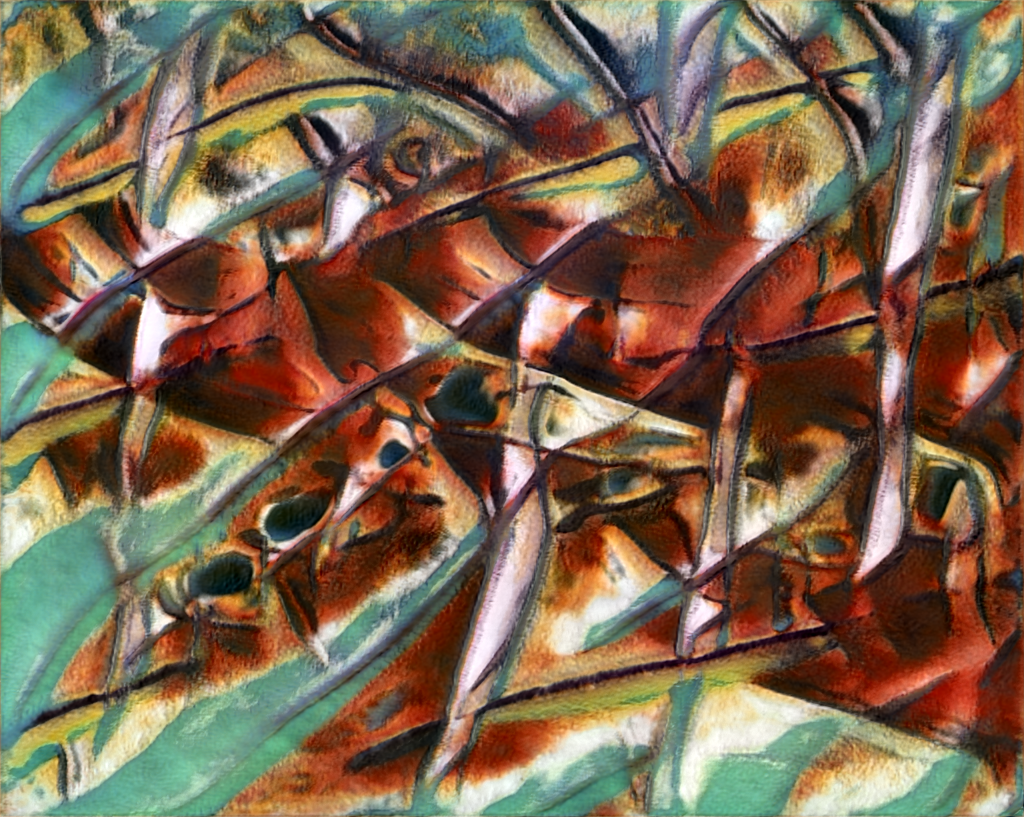

In [5]:
chosen_thumbnail = 17 #@param {type:"slider", min:1, max:21, step:1}
image = Image.open(image_files[chosen_thumbnail-1])
size = 1024
aspect = aspect_ratios[chosen_thumbnail-1]

if aspect<1:
  newsize = (int(size * aspect), size)
else:
  newsize = (size, int(size / aspect))

resized = image.resize(newsize)
resized